**Importing required Libraries**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

## **Data pre-processing**

In [ ]:

# paths to the dataset
train_dir = '/content/drive/MyDrive/Rock-Paper-Scissors/train'
test_dir = '/content/drive/MyDrive/Rock-Paper-Scissors/test'
val_dir = '/content/drive/MyDrive/Rock-Paper-Scissors/validation/'
class_dict = {'rock': 0, 'paper': 1, 'scissors': 2}

# target image size
image_size = (224, 224) 

# Load and preprocess the dataset
def load_and_preprocess_data(directory, class_dict, image_size):
    X = []
    y = []
    for class_name in class_dict.keys():
        class_dir = os.path.join(directory, class_name)
        label = class_dict[class_name]
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = cv2.resize(image, image_size)  # Resize to desired size
            X.append(image)
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess the training data
X_train, y_train = load_and_preprocess_data(train_dir, class_dict, image_size)

# Load and preprocess the test data
X_test, y_test = load_and_preprocess_data(test_dir, class_dict, image_size)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert labels to one-hot encoded vectors
num_classes = 3  # rock, paper, scissors
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0

# Print information about the data
print("Number of training samples:", X_train.shape[0])
print("Number of validation samples:", X_val.shape[0])
print("Image shape:", X_train[0].shape)
print("Number of classes:", num_classes)

Number of training samples: 2032
Number of validation samples: 508
Image shape: (224, 224, 3)
Number of classes: 3


## **Data Augmentation**

In [ ]:
# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Random rotation (20 degrees)
    width_shift_range=0.2,  # Random horizontal shift (20% of image width)
    height_shift_range=0.2,  # Random vertical shift (20% of image height)
    shear_range=0.2,  # Random shear transformation (20 degrees)
    zoom_range=0.2,  # Random zoom (20%)
    horizontal_flip=True  # Random horizontal flip
)

# Define the batch size for training data
batch_size = 32

# Create a generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the validation and test ImageDataGenerator without data augmentation
val_test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values
)
# Create a generator for test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,  # test data directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Disable shuffling of images
)


Found 2540 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


### **Visualization**

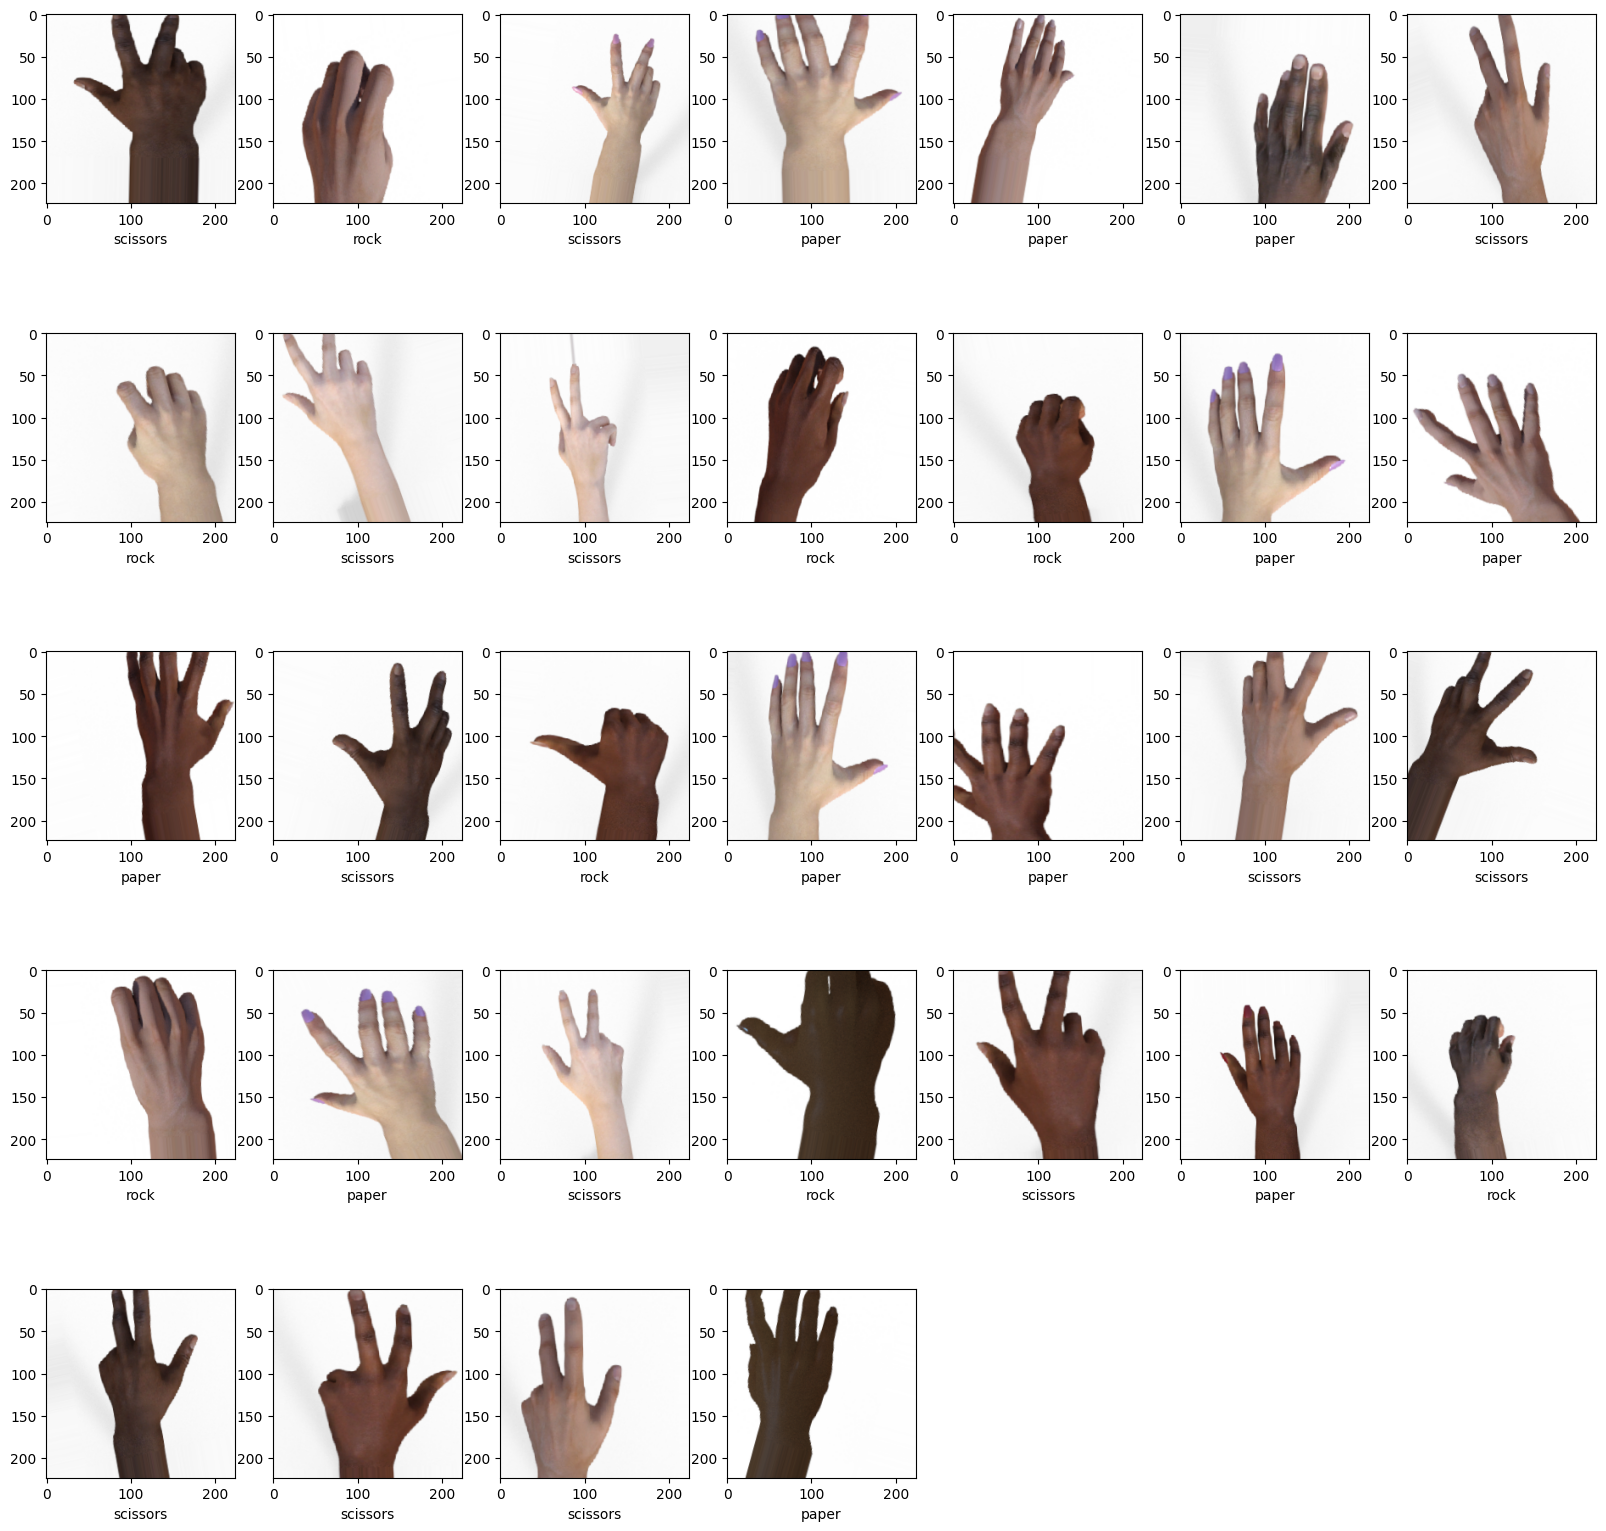

In [ ]:
# Load and visualize some random samples from the train dataset

# Load a batch of images and labels from the train generator
sample_images, sample_labels = next(train_generator)

# Get class names and labels
class_names = train_generator.class_indices
class_labels = list(class_names.keys())

# Save class names to a JSON file
with open('/content/drive/MyDrive/Rock_Paper_Scissor_Model/class_names.json', 'w') as f:
    json.dump(class_names, f)

# Determine the number of rows and columns based on batch size
num_samples = len(sample_images)
num_rows = int(np.sqrt(num_samples))
num_cols = int(np.ceil(num_samples / num_rows))

# Create a grid of subplots to display the images
plt.figure(figsize=(20, 20))
for i in range(len(sample_images)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.grid(False)
    # Convert image from array to PIL Image format
    image = Image.fromarray(np.uint8(sample_images[i] * 255))
    plt.imshow(image)
    plt.xlabel(class_labels[np.argmax(sample_labels[i])])
plt.show()



## **ResNet50** *Pre-trained CNN* architecture model

In [ ]:
# Load ResNet50 pre-trained model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for hand gesture recognition
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions, name='ResNet50')

# Print the model summary 
model.summary()

# Compile the model
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### **Train the model**

In [ ]:
# Total number of training images
total_train_images = len(train_generator.filenames)

# Total number of validation images
total_val_images = len(test_generator.filenames)

num_epochs = 15 # Number of epochs for training
steps_per_epoch = total_train_images // batch_size # steps_per_epoch
validation_data = test_generator # validation data generator
validation_steps = total_val_images // batch_size # validation_steps

# Define the file path for saving the model
model_file_path = '/content/drive/MyDrive/Rock_Paper_Scissor_Model/RPS_Resnet50Model.hdf5'

# Create a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(model_file_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train your model with the checkpoint callback and get the history object
history = model.fit(train_generator, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=validation_data, validation_steps=validation_steps,
                    callbacks=[checkpoint])

# Access the training loss, validation loss, and other metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/15
79/79 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9980
Epoch 1: val_loss improved from inf to 0.68451, saving model to /content/drive/MyDrive/Rock_Paper_Scissor_Model/RPS_Resnet50Model.hdf5
79/79 [==============================] - 53s 663ms/step - loss: 0.0044 - accuracy: 0.9980 - val_loss: 0.6845 - val_accuracy: 0.7955
Epoch 2/15
79/79 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988
Epoch 2: val_loss improved from 0.68451 to 0.29583, saving model to /content/drive/MyDrive/Rock_Paper_Scissor_Model/RPS_Resnet50Model.hdf5
79/79 [==============================] - 51s 647ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.2958 - val_accuracy: 0.8693
Epoch 3/15
79/79 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9988
Epoch 3: val_loss did not improve from 0.29583
79/79 [==============================] - 49s 619ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 38.3530 - val_accuracy: 0.3523


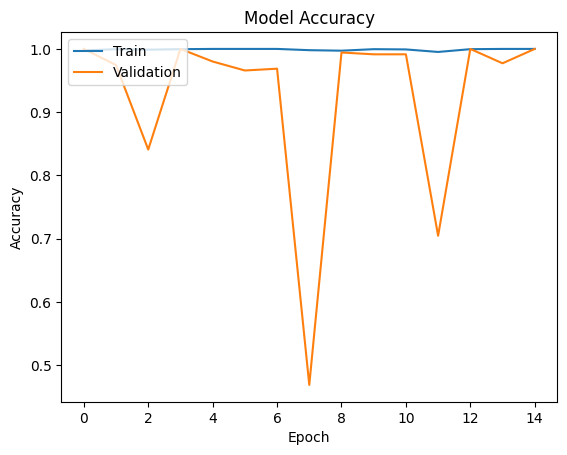

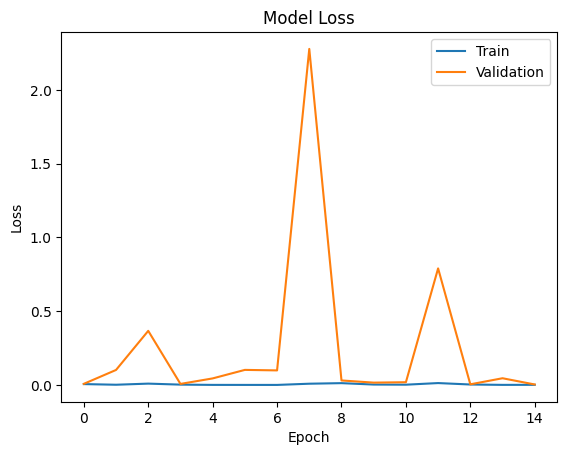

In [ ]:
# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
